https://www.kaggle.com/datasets/thedevastator/dataset-for-developing-natural-language-interfac

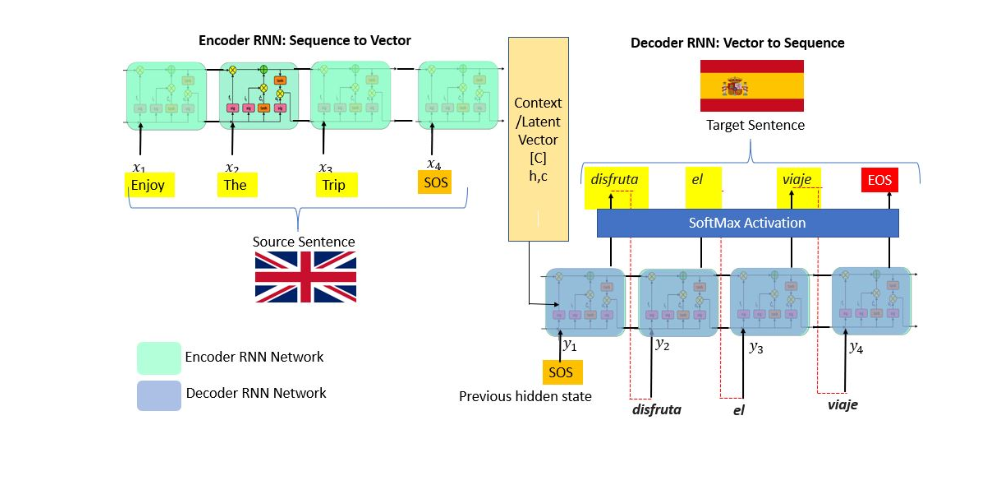

# Imports and loading data

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import numpy as np
import ast
import pandas as pd
import os
import json

tf.random.set_seed(42)
np.random.seed(42)


In [32]:


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the CSV file
file_path = '/content/drive/MyDrive/Epsilon/Final DNN Project/train.csv'
try:
    df = pd.read_csv(file_path)
    print("File loaded successfully.")

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File loaded successfully.


,phase,question,table,sql
0,1,Tell me what the notes are for South Australia,"{'header': array(['State/territory', 'Text/bac...",{'human_readable': 'SELECT Notes FROM table WH...
1,1,What is the current series where the new serie...,"{'header': array(['State/territory', 'Text/bac...",{'human_readable': 'SELECT Current series FROM...
2,1,What is the format for South Australia?,"{'header': array(['State/territory', 'Text/bac...",{'human_readable': 'SELECT Format FROM table W...
3,1,Name the background colour for the Australian ...,"{'header': array(['State/territory', 'Text/bac...",{'human_readable': 'SELECT Text/background col...
4,1,how many times is the fuel propulsion is cng?,"{'header': array(['Order Year', 'Manufacturer'...",{'human_readable': 'SELECT COUNT Fleet Series ...


# Text Preprocessing and TensorDataSet Preperation

## Spliting input target

In [33]:
sqlLst=np.array(df["sql"].apply(lambda x: eval(x, {"np": np, "array": np.array, "int32": np.int32, "object": object})["human_readable"]).values)
Qlst=np.array(df["question"].values)
#lst=[list(x) for x in zip(Qlst,sqlLst)]
print(sqlLst.shape)
print(Qlst.shape)


(56355,)
(56355,)


## Check for nan or empty string

In [34]:
# --- Logic to find NaN or empty strings ---

# 1. Create a boolean mask: True if the element is np.nan OR an exact empty string (x == '').
# This handles the mix of string and float (np.nan) types in the object array.
is_nan_or_empty = np.array([
    (isinstance(x, float) and np.isnan(x)) or (x == '')
    for x in sqlLst
])
is_nan_or_empty.sum()

np.int64(0)

In [35]:
is_nan_or_empty = np.array([
    (isinstance(x, float) and np.isnan(x)) or (x == '')
    for x in Qlst
])
is_nan_or_empty.sum()

np.int64(0)

## Check max words length in input and target for victorization

In [36]:
# Add start/end
sqlLst = np.array(["<start> " + s + " <end>" for s in sqlLst])
input_Max_Length_Words =  max(len(sentence.split()) for sentence in Qlst)
Output_Max_Length_Words =  max(len(sentence.split()) for sentence in sqlLst)
print(input_Max_Length_Words)
print(Output_Max_Length_Words)

44
84


## Input Text Vectorization (encoding)

In [37]:
# Input (Question)
sequence_length = max(input_Max_Length_Words, Output_Max_Length_Words)
Q_vectorizer = TextVectorization(
    output_mode="int",
    output_sequence_length=sequence_length,
    split='whitespace',
    standardize="lower"

)

Q_vectorizer.adapt(Qlst)
Q_encoded = Q_vectorizer(Qlst)

In [38]:
Q_vectorizer.vocabulary_size()

53877

## output Text Vectorization (encoding)

In [39]:
# output (Sql)
Sql_vectorizer = TextVectorization(
    output_mode="int",
     output_sequence_length=sequence_length,
    split='whitespace',
    standardize="lower"
)

Sql_vectorizer.adapt(sqlLst)

sqls_in  =[s.replace('<end>', '').strip() for s in sqlLst]
Sql_in_decoder_encoded = Sql_vectorizer(sqls_in)
sqls_out = [s.replace('<start>', '').strip() for s in sqlLst]
Sql_out_decoder_encoded = Sql_vectorizer(sqls_out)

In [40]:
Sql_vectorizer.vocabulary_size()

41388

## Save TextVectorization layers

In [41]:
def save_vectorizer(vectorizer, name):
    vocab = vectorizer.get_vocabulary()
    with open(f"/content/drive/MyDrive/Epsilon/Final DNN Project/{name}_vocab.txt", "w") as f:
        f.write("\n".join(vocab))
    with open(f"/content/drive/MyDrive/Epsilon/Final DNN Project/{name}_config.json", "w") as f:
        json.dump(vectorizer.get_config(), f)
    print(f"Saved {name}")

def load_vectorizer(name):
    with open(f"/content/drive/MyDrive/Epsilon/Final DNN Project/{name}_vocab.txt") as f:
        vocab = f.read().splitlines()
    with open(f"/content/drive/MyDrive/Epsilon/Final DNN Project/{name}_config.json") as f:
        config = json.load(f)
    vectorizer = TextVectorization.from_config(config)
    vectorizer.set_vocabulary(vocab)
    print(f"Loaded {name}")
    return vectorizer

save_vectorizer(Q_vectorizer, "Q_vectorizer")
save_vectorizer(Sql_vectorizer, "Sql_vectorizer")
#Q_vectorizer = load_vectorizer("Q_vectorizer")



Saved Q_vectorizer
Saved Sql_vectorizer


## Tensor Dataset

In [43]:
total_size = len(Q_encoded)
val_split = 0.2
val_size = int(total_size * val_split)
train_size = total_size - val_size

ds = tf.data.Dataset.from_tensor_slices(((Q_encoded,Sql_in_decoder_encoded),Sql_out_decoder_encoded))

# Shuffle before splitting (important!)
ds = ds.shuffle(buffer_size=total_size, seed=42)

# Split into train and validation
val_ds = ds.take(val_size)
train_ds = ds.skip(val_size)

batch_size = 32
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print(len(ds))
for q, sql in ds.take(1):
    print(f"Q_encoded: {q}")
    print(f"Sql_encoded: {sql}")

ds = ds.shuffle(10).batch(32)

56355
Q_encoded: (<tf.Tensor: shape=(84,), dtype=int64, numpy=
array([   17,    20,   259,    30,  2321, 39427,   136,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])>, <tf.Tensor: shape=(84,), dtype=int64, numpy=
array([    6,     5,    14,   178,     3,     4,     8,    20,     2,
        1858, 30334,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0, 

## Model

Input the sequence:
- The model's encoder processes the entire input sequence (e.g., an English sentence).
Initial decoding: The decoder starts with an initial token, like [START], and uses the encoder's output to predict the first word of the output sequence (e.g., a French word).
Autoregressive generation: The predicted word from the previous step is then fed back into the decoder as input for the next step. This process repeats, with the model using its own output to generate the subsequent word, until an [END] token is produced.

<table>
<tr><th>Timestep</th><th>Hidden output</th></tr>
<tr><td>w1</td>	<td>h1</td></tr>
<tr><td>w2</td>	<td>h2</td></tr>
<tr><td>w3</td>	<td>h3</td></tr>
</table>


- Without return_sequences: you get only h3
- With return_sequences=True: you get [h1, h2, h3]

In [ ]:
#model=None
if model is None:
    print("No existing model found — creating a new one...")
    embed_dim = 256
    rnn_units = 50
    encoder_Voc_Size= len(Q_vectorizer.get_vocabulary())
    decoder_Voc_Size= len(Sql_vectorizer.get_vocabulary())



    # Encoder
    encoder_inputs =Input(shape=(None,), dtype="int32",name="Encoder_input")
    hidden = Embedding(input_dim=encoder_Voc_Size, output_dim=embed_dim,name="Encoder_Embedding")(encoder_inputs)
    _, state_h, state_c = LSTM(rnn_units, return_state=True,name="Encoder_Lstm")(hidden) #return_state=True return -> state_h → the final hidden state (short-term memory) state_c → the final cell state (long-term memory)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None,), dtype="int32",name="Decoder_input")
    hidden = Embedding(input_dim=decoder_Voc_Size, output_dim=embed_dim,name="Decoder_Embedding")(decoder_inputs)
    decoder_lstm =LSTM(rnn_units, return_sequences=True, return_state=True,name="Decoder_Lstm")
    decoder_outputs, _, _ = decoder_lstm(hidden, initial_state=encoder_states)
    decoder_outputs = Dense(decoder_Voc_Size, activation="softmax")(decoder_outputs)

    # Model
    model = Model(inputs=[encoder_inputs, decoder_inputs],outputs= decoder_outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.summary()

No existing model found — creating a new one...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Encoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Embedding   │ (None, None, 256) │ 13,792,512 │ Encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Embedding   │ (None, None, 256) │ 10,595,328 │ Decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Lstm (LSTM) │ [(None, 50),      │     61,400 │ Encoder_Embeddin… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Lstm (LSTM) │ [(None, None,     │     61,400 │ Decoder_Embeddin… │
│                     │ 50), (None, 50),  │            │ Encoder_Lstm[0][… │
│                     │ (None, 50)]       │            │ Encoder_Lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  2,110,788 │ Decoder_Lstm[0][… │
│                     │ 41388)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,621,428 (101.55 MB)

 Trainable params: 26,621,428 (101.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

#history = model.fit(
 #  (Q_encoded,Sql_encoded),
#Sql_encoded,
  #  #decoder_target_data,
 #   batch_size=32,
  #  epochs=50,
  #  validation_split=0.1
#)
model.fit(train_ds,validation_data=val_ds, epochs=5)



Epoch 1/5
 157/1409 ━━━━━━━━━━━━━━━━━━━━ 2:01:56 6s/step - accuracy: 0.9725 - loss: 0.1245

KeyboardInterrupt: 

## Test

In [29]:
# Load the CSV file
file_path = '/content/drive/MyDrive/Epsilon/Final DNN Project/test.csv'
df = pd.read_csv(file_path)


In [30]:
sqlLst_test=np.array(df["sql"].apply(lambda x: eval(x, {"np": np, "array": np.array, "int32": np.int32, "object": object})["human_readable"]).values)
Qlst_test=np.array(df["question"].values)

sqlLst_test = np.array(["<start> " + s + " <end>" for s in sqlLst_test])

sqls_in_test  =[s.replace('<end>', '').strip() for s in sqlLst_test]
Sql_in_decoder_encoded_test = Sql_vectorizer(sqls_in_test)
sqls_out_test = [s.replace('<start>', '').strip() for s in sqlLst_test]
Sql_out_decoder_encoded_test = Sql_vectorizer(sqls_out_test)

Q_encoded_test = Q_vectorizer(Qlst_test)

loss, acc = model.evaluate([Q_encoded_test, Sql_in_decoder_encoded_test], Sql_out_decoder_encoded_test)



497/497 ━━━━━━━━━━━━━━━━━━━━ 84s 165ms/step - accuracy: 0.9436 - loss: 0.5619


## save model

In [ ]:
import os

save_dir = "/content/drive/MyDrive/Epsilon/Final DNN Project"
os.makedirs(save_dir, exist_ok=True)

model.save(os.path.join(save_dir, "full_model.keras"))


## Load Model

In [44]:
def LoadModel():
    # Path to your saved model
    model_path = "/content/drive/MyDrive/Epsilon/Final DNN Project/full_model.keras"#"/kaggle/input/full-model/tensorflow2/default/1/sql_seq2seq_model/full_model.keras"

    # Check if the model file exists
    if os.path.exists(model_path):
        print("Model found — loading existing model...")
        model = tf.keras.models.load_model(model_path)
        return model
    else:
        print("Model not found — you may need to train and save it first.")
        return None

In [45]:
model = LoadModel()

Model found — loading existing model...


## Load TextVectorization layers

In [46]:
# Load Q_vectorizer
Q_vectorizer= load_vectorizer("Q_vectorizer")

# Load Sql_vectorizer
Sql_vectorizer= load_vectorizer("Sql_vectorizer")

Loaded Q_vectorizer
Loaded Sql_vectorizer


# Inference
is the process of using a trained model to generate an output sequence for a new, unseen input. Unlike training, which uses the "teacher forcing" method where the correct previous word is fed as input, inference is autoregressive:
- the model takes its own previous prediction as input to generate the next word in the sequence, repeating this process until it generates an end-of-sequence token. This is the phase where the model is used for its intended task, such as translating a sentence or completing text, without knowing the correct answer beforehand.



## Encoder :
- from the previouse model, grap the encoder inputs and its final states

In [47]:
# Get the encoder layers from the full model
encoder_inputs = model.input[0]

print(encoder_inputs.name)
print(encoder_inputs)

Encoder_input
<KerasTensor shape=(None, None), dtype=int32, sparse=False, ragged=False, name=Encoder_input>


In [48]:
print(model.layers[4].name)
encoder_outputs, state_h_enc, state_c_enc = model.layers[4].output
encoder_states = [state_h_enc, state_c_enc]

Encoder_Lstm


In [49]:
#Create the inference encoder model
encoder_model = Model(inputs =encoder_inputs,outputs= encoder_states)
encoder_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Encoder_input (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Embedding (Embedding)   │ (None, None, 256)      │    13,792,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Lstm (LSTM)             │ [(None, 50), (None,    │        61,400 │
│                                 │ 50), (None, 50)]       │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,853,912 (52.85 MB)

 Trainable params: 13,853,912 (52.85 MB)

 Non-trainable params: 0 (0.00 B)

##  2. Build the decoder model

- This model takes:

  - a single token (the previous one generated)

  - previous LSTM states (h, c)

- and outputs:

  - next token probabilities

  - next LSTM states

In [50]:
latent_dim = 50  # same as rnn_units = 50


# Decoder  from encoder states
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get embedding and LSTM layers from the trained model
dec_emb_layer = model.layers[3]  # decoder embedding
decoder_lstm = model.layers[5]   # decoder LSTM
decoder_dense = model.layers[6]  # final dense layer

# Use them to define step-by-step decoding
dec_inputs = model.input[1]  # decoder input placeholder
dec_emb2 = dec_emb_layer(dec_inputs)
dec_outputs, state_h_dec, state_c_dec = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
dec_states = [state_h_dec, state_c_dec]
dec_outputs = decoder_dense(dec_outputs)

decoder_model = Model(
    inputs =[dec_inputs] + decoder_states_inputs, #flatten to be like this [dec_inputs, state_input_h, state_input_c]
    outputs=[dec_outputs] + dec_states
)
decoder_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Embedding   │ (None, None, 256) │ 10,595,328 │ Decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Lstm (LSTM) │ [(None, None,     │     61,400 │ Decoder_Embeddin… │
│                     │ 50), (None, 50),  │            │ input_layer_4[0]… │
│                     │ (None, 50)]       │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None,      │  2,110,788 │ Decoder_Lstm[1][… │
│                     │ 41388)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,767,516 (48.70 MB)

 Trainable params: 12,767,516 (48.70 MB)

 Non-trainable params: 0 (0.00 B)

## decode sequence function

In [51]:
def decode_sequence(input_seq, max_len=50):
    # Encode the question
    states_value = encoder_model.predict(input_seq)

    # Create start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = Sql_vectorizer(['<start>']).numpy()[0][0]

    stop_condition = False
    decoded_sentence = []

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq]+ states_value)

        # Get most probable token


        #(batch_size, sequence_length, vocab_size)
        #Part	Meaning
        #0	Take the first (and only) example in the batch (since batch size = 1 during inference).
        #-1	Take the last time step in the sequence (the most recent predicted token).
        #:	Take all vocabulary probabilities for that token (a vector of length vocab_size).
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = Sql_vectorizer.get_vocabulary()[sampled_token_index]
        decoded_sentence.append(sampled_word)

        # Stop if end token or max length
        if (sampled_word == '<end>' or len(decoded_sentence) > max_len):
            stop_condition = True

        # Update target sequence for next step
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return ' '.join(decoded_sentence[:-1])  # remove <end>


In [1]:
sample_question = "What is the smallest possible radius?"
input_seq = Q_vectorizer([sample_question])
sql_query = decode_sequence(input_seq)
print(sql_query)


NameError: name 'Q_vectorizer' is not defined

# Streamlet

In [ ]:
#!pip install streamlit

In [ ]:
import streamlit as st

ModuleNotFoundError: No module named 'streamlit'

In [ ]:
%%writefile QuestionToSQL_Streamlet.py

import streamlit as st
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import *
import numpy as np
import ast
import pandas as pd
import os
import json

def LoadModel():
    # Path to your saved model
    model_path = "/content/drive/MyDrive/Epsilon/Final DNN Project/full_model.keras"#"/kaggle/input/full-model/tensorflow2/default/1/sql_seq2seq_model/full_model.keras"
    model_path = "full_model.keras"
    # Check if the model file exists
    if os.path.exists(model_path):
        print("Model found — loading existing model...")
        model = tf.keras.models.load_model(model_path)
        return model
    else:
        print("Model not found — you may need to train and save it first.")
        return None

def load_vectorizer(name):
    with open(f"/content/drive/MyDrive/Epsilon/Final DNN Project/{name}_vocab.txt") as f:
        vocab = f.read().splitlines()
    with open(f"/content/drive/MyDrive/Epsilon/Final DNN Project/{name}_config.json") as f:
        config = json.load(f)
    vectorizer = TextVectorization.from_config(config)
    vectorizer.set_vocabulary(vocab)
    print(f"Loaded {name}")
    return vectorizer


model = LoadModel()
#loac text vectorizers

# Load Q_vectorizer
Q_vectorizer= load_vectorizer("Q_vectorizer")

# Load Sql_vectorizer
Sql_vectorizer= load_vectorizer("Sql_vectorizer")

#Encoder layers
encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.layers[4].output  # LSTM layer index may differ
encoder_states = [state_h_enc, state_c_enc]
encoder_model = tf.keras.Model(inputs =encoder_inputs,outputs= encoder_states)
encoder_model.summary()

#decoder layers
rnn_units =50
latent_dim = rnn_units

# Decoder  from encoder states
decoder_state_input_h = tf.keras.Input(shape=(latent_dim,))
decoder_state_input_c = tf.keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get embedding and LSTM layers from the trained model
dec_emb_layer = model.layers[3]  # decoder embedding
decoder_lstm = model.layers[5]   # decoder LSTM
decoder_dense = model.layers[6]  # final dense layer

# Use them to define step-by-step decoding
dec_inputs = model.input[1]  # decoder input placeholder
dec_emb2 = dec_emb_layer(dec_inputs)
dec_outputs, state_h_dec, state_c_dec = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
dec_states = [state_h_dec, state_c_dec]
dec_outputs = decoder_dense(dec_outputs)

decoder_model = tf.keras.Model(
    inputs =[dec_inputs] + decoder_states_inputs,
    outputs=[dec_outputs] + dec_states
)
decoder_model.summary()



def decode_sequence(input_seq, max_len=50):
    # Encode the question
    states_value = encoder_model.predict(input_seq)

    # Create start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = Sql_vectorizer(['<start>']).numpy()[0][0]

    stop_condition = False
    decoded_sentence = []

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Get most probable token


        #(batch_size, sequence_length, vocab_size)
        #Part	Meaning
        #0	Take the first (and only) example in the batch (since batch size = 1 during inference).
        #-1	Take the last time step in the sequence (the most recent predicted token).
        #:	Take all vocabulary probabilities for that token (a vector of length vocab_size).
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = Sql_vectorizer.get_vocabulary()[sampled_token_index]
        decoded_sentence.append(sampled_word)

        # Stop if end token or max length
        if (sampled_word == '<end>' or len(decoded_sentence) > max_len):
            stop_condition = True

        # Update target sequence for next step
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return ' '.join(decoded_sentence[:-1])  # remove <end>


st.set_page_config(layout= 'wide', page_title= 'Question to SQL Query Generator')
html_title = "<h1 style=color:white;text-align:center;> Question to SQL Query Generator </h1>"
st.markdown(html_title, unsafe_allow_html=True)

df = pd.read_csv('train.csv')
df.dropna(inplace=True)
st.dataframe(df.head(20))


user_question = st.text_input("Enter your question:")
if st.button("Generate SQL Query"):
    input_seq = Q_vectorizer([user_question])
    sql_query = decode_sequence(input_seq)
    st.write("Generated SQL Query:")
    st.code(sql_query)



In [ ]:
! streamlit run QuestionToSQL_Streamlet.py